# Import modules

In [1]:
import sys
from unipath import Path

# append codelib to sys path ~ will only work if this jupyter notebook path is sys.path[0]
p = Path(sys.path[0])
codelib_path = str(p.parent + Path('\\codelib'))
sys.path.insert(0, codelib_path)

# import codelib
from helpers import *
from mean_variance import *
import enhanced_portfolio_optimization as epo

# other modules
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Import data

In [2]:
# setting dates
start = "1900-01-01"
end   = "2022-01-01"
port  = "5_Industry_Portfolios"

# pulling data
df = pdr.famafrench.FamaFrenchReader(port, start, end).read()[0]
df = df.replace(-99.99,0) # replace nan values
df = df / 100 # changing format to decimals

# risk free rate
rf = 0.0001

# returns in array
ret = df.to_numpy()

# stocks
#ret = daily_return("2012-01-01", end, ["TSLA", "IBM", "GOOG", "FB"]).to_numpy()
#ret

# CRSP stocks
#df = pd.read_csv(r"C:\Users\Gustav\school\master thesis\empirical_testing\main_df.csv")
#ret = df.iloc[:,1:].to_numpy().T

In [3]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

# 1-period portfolio variance

**Equations**

Portfolio variance of three assets.

$$
\sigma_P^2 = w_1^2 \sigma^2_1 + w_2^2 \sigma^2_2 + w_3^2 \sigma^2_3 + 2 w_1 w_2 \sigma_{1,2} + 2 w_1 w_3 \sigma_{1,3} + + 2 w_2 w_3 \sigma_{2,3}
$$

Generalized equation

$$
\sigma_P^2 = W^\intercal (\Sigma \cdot W)
$$

* $W$: Vector of asset weights.
* $\Sigma$: Variance-covariance matrix.

### Creating function for portfolio variance

In [4]:
def portfolio_variance(return_series, weights):
    
    # calculating covariance matrix
    covar = np.cov(return_series.T)
    
    # calculating portfolio variance
    port_var = np.dot(weights.T, np.dot(covar,weights))
    
    return port_var

# Using real data

**Joblist** <br>
* Calculate 1-period variance for every period.
* Compare with variance of full time horizon.

In [5]:
port_var = []

# calculating 1 period variance for every time step
for period in range(0,len(ret)-1):
    
    # obtaining instance of returns
    idx_one = period
    idx_two = period+2
    period_ret = ret[idx_one:idx_two]
    
    # calculating equal weights
    weights = np.linspace(1/len(period_ret.T),
                         1/len(period_ret.T),
                         len(period_ret.T))
    
    # calculating portfolio variance
    port_var.append(portfolio_variance(period_ret, weights))

# calculating equal weighted portfolio returns
eq_port = equal_weighted_portfolio(ret)

In [6]:
print("Mean of 1-period variances:", np.round(np.mean(port_var),6))
print("---")
print("Variance of equal weighted portfolio returns:", np.round(np.var(eq_port),6))

Mean of 1-period variances: 0.002396
---
Variance of equal weighted portfolio returns: 0.002687


# Implications of shrinkage

In this section sharpe ratios for different shrinkage parameters are calculated. In order to carry out this, I have made a function which takes in a series of returns, the proceeding set of returns, and an accuracy parameter. The accuracy parameter determines the number of steps between 0 and 1 for the shrinkage parameter. Now, with the series of returns, the first half of the periods are used as the first set of returns to estimate the covaraince matrix, and from there one period is included in the covariance estimation for each step. For every step the proceding returns are used to calculate the realized returns and realized variance.

```different_shrinkage_parameters(ret_train, ret_test, rf=0.0, ledoit_wolf=False, accuracy)```

1. Define initial ```ret_train```.
2. Loop through every period proceeding the initial ```ret_train```.
3. Calculate realized sharpe ratio for every time step and store in array.

In [7]:
# the number of values between 0 and 1
accuracy = 10

# the number of windows, here set as a fraction of the total length
num_windows = int(0.5 * len(ret))
arr = np.empty([num_windows, accuracy])

idx = 0
for window in range((len(ret)-num_windows), len(ret)):
    
    # define ret train and ret test
    ret_train = ret[idx:window]
    ret_test = ret[window]
    
    # appending sharpe ratios
    arr[idx] = epo.different_shrinkage_parameters(ret_train, ret_test, rf=0.0, ledoit_wolf=False, accuracy=accuracy)
    
    idx += 1

In [8]:
size = 12*5
n_rows = len(arr) + 1 - size

mv_arr = np.empty([accuracy, n_rows])

idx = 0
for roll_window in range(0, len(arr[0])):
    
    mva = moving_average(arr[:,roll_window], size)
    
    mv_arr[idx] = mva
    
    idx += 1

In [9]:

sharpe_arr = mv_arr.T

sharpe_arr = np.where(sharpe_arr > 30, np.random.rand(), sharpe_arr)

opt_shrink = []

for period in sharpe_arr:
    
    max_sharpe = np.amax(period)
    
    idx_loc_sharpe = np.where(sharpe_arr==max_sharpe)[1] # column index
    
    optimal_shrink = np.linspace(0,1,accuracy)[idx_loc_sharpe]
    
    opt_shrink.append(optimal_shrink)
    

In [10]:
np.amax(sharpe_arr)

19.747276255515224

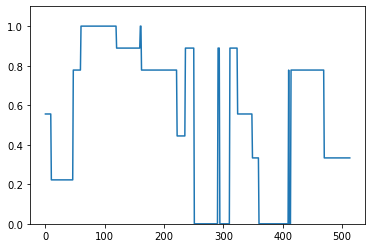

In [11]:
plt.plot(opt_shrink)

plt.ylim(0,1.1)

plt.show()

In [12]:
np.amax(arr)

2320.80528929885

In [13]:
np.where(arr==np.amax(arr))

(array([159], dtype=int64), array([7], dtype=int64))

In [14]:
arr[159]

array([  19.54280736,   28.01817805,   25.34598891,   31.38614739,
         43.83343179,   69.61705786,  144.71852143, 2320.8052893 ,
        192.56588289,   99.08165244])

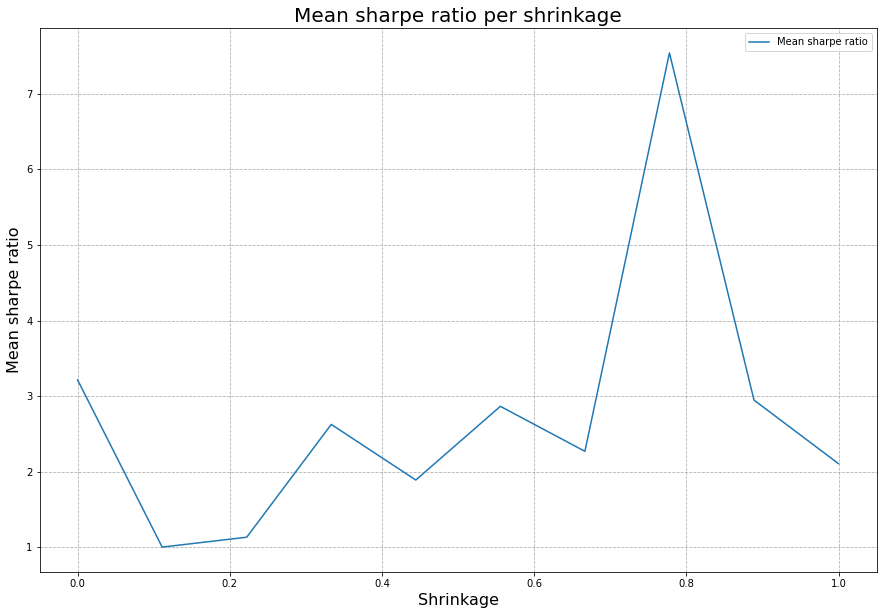

In [15]:
# plotting
fig = plt.figure(figsize=(15,10))

plt.plot(np.linspace(0,1,accuracy), np.mean(arr, axis=0), label="Mean sharpe ratio")

plt.title("Mean sharpe ratio per shrinkage", size=20)
plt.ylabel("Mean sharpe ratio", size=16)
plt.xlabel("Shrinkage", size=16)

plt.legend()
plt.grid(linestyle="--")

# Optimal shrinkage

In this section a function for returning the optimal shrinkage parameter is deployed. The function simply calculates realized sharpe ratios for different shrinkage values and returns the shrinkage which yielded the highest realized sharpe ratio for that period.

In [16]:
# optimal shrinkage
opt_shr = epo.optimal_shrinkage_parameters(ret, accuracy=accuracy, ratio=0.5)

# getting frequency of shrinkage estimates
shr_freq = []
for shrink in np.linspace(0,1,accuracy):
    
    freq = (opt_shr==shrink).sum()
    shr_freq.append(freq)

### Plotting

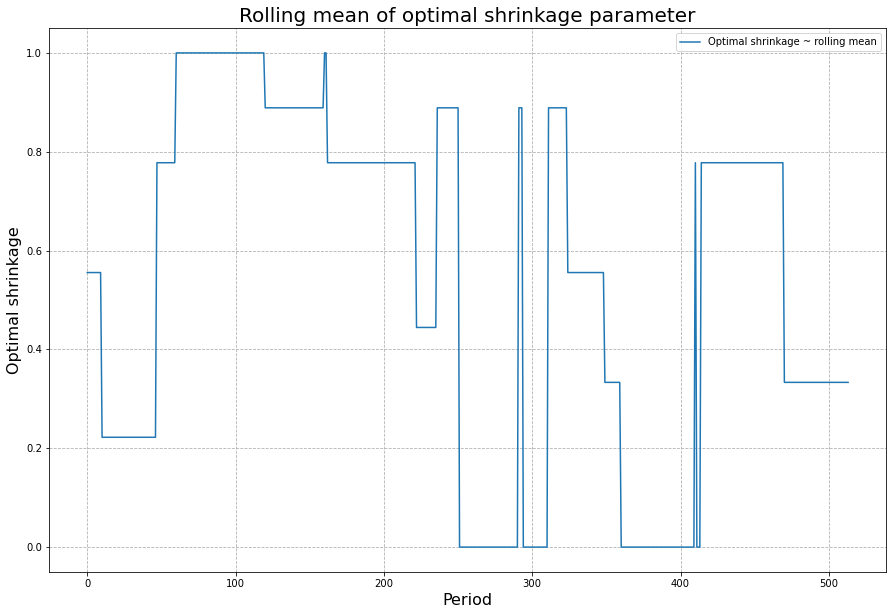

In [17]:
# rolling mean of optimal shrinkage
y = pd.Series(opt_shrink).rolling(1).mean()
x = range(len(y))

# plotting
fig = plt.figure(figsize=(15,10))

plt.plot(x,y,label="Optimal shrinkage ~ rolling mean")

plt.title("Rolling mean of optimal shrinkage parameter", size=20)
plt.xlabel("Period", size=16)
plt.ylabel("Optimal shrinkage", size=16)

plt.legend()
plt.grid(linestyle="--")

plt.show()

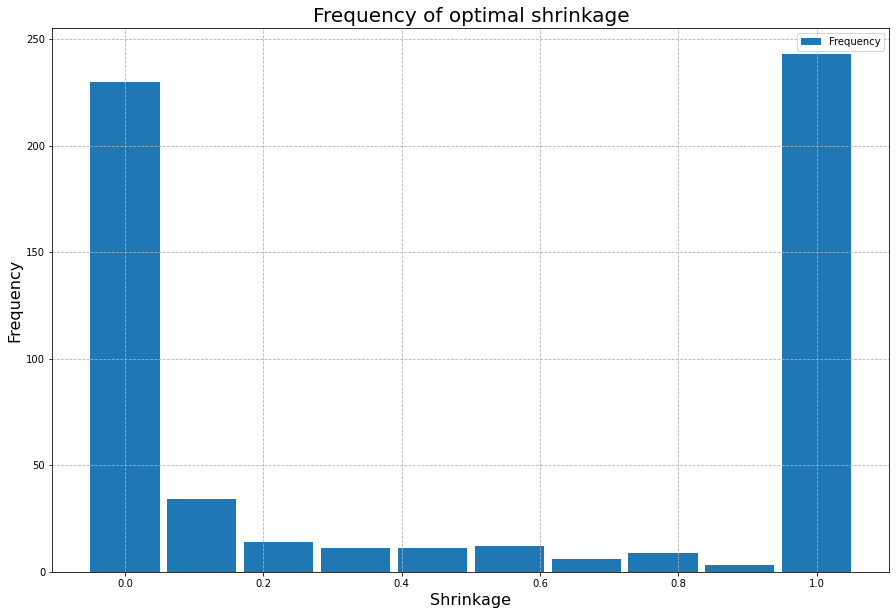

In [18]:
# plotting
fig = plt.figure(figsize=(15,10))

plt.bar(np.linspace(0,1,accuracy), shr_freq, width=0.1, label="Frequency")

plt.title("Frequency of optimal shrinkage", size=20)
plt.xlabel("Shrinkage", size=16)
plt.ylabel("Frequency", size=16)

plt.legend()
plt.grid(linestyle="--")

plt.show()